# Training of U-NET


In [46]:
# ⌨️ add path:
data_path = "/home/jovyan/Deep Learning for Medical Image Analysis/ACDC/Resources"


In [47]:
# check if data_path exists:
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["training", "testing"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train, val and test folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


In [48]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
import tensorflow as tf
import wandb
import nibabel as nib
from skimage import metrics
from sklearn.metrics import jaccard_score
from medpy.metric.binary import hd, dc
import scipy.ndimage as ndi
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    MapTransform,
    Randomizable,
    AddChannel,
    AddChanneld,
    CastToTyped,
    Compose,
    LoadImage,
    LoadImaged,
    Lambda,
    Lambdad,
    RandSpatialCrop,
    RandSpatialCropd,
    Resize,
    ToTensor,
    ToTensord,
    Orientation, 
    Rotate,
    RandFlipd,
    RandAffined,
    RandGaussianNoised,
    RandRotated
)

In [49]:
# Build function that writes list of paths to images automatically, based on the root folder of the data and the filename structure:
def build_dict(data_path, mode):
    dicts = [] 
    patient_folders = glob.glob(os.path.join(data_path, mode, 'patient*'))
    for patient_folder in patient_folders:
        patient_id = os.path.basename(patient_folder)
        all_paths = glob.glob(os.path.join(patient_folder, f'{patient_id}_frame*.nii.gz')) # path to all 'frame' image files (both mask and img)
        time_path = os.path.join(patient_folder,f'{patient_id}_4d.nii.gz') # path to the '4d' image, so the image acquired over time
        frame_indices = sorted(list(set([os.path.basename(path).split('_frame')[-1].split('.')[0] for path in all_paths])))
        for i in range(0,len(frame_indices),2): # loop over every other frame index since you only want the number (and also got '_gt' in frame_indices)
            frame_index = frame_indices[i]
            if frame_index == '01':
                img_ED = f'{patient_id}_frame{frame_index}.nii.gz' # diastole images are always frame 01
                mask_ED = f'{patient_id}_frame{frame_index}_gt.nii.gz'
                ED_img_path = os.path.join(patient_folder,img_ED)
                ED_mask_path = os.path.join(patient_folder,mask_ED)
            else:
                img_ES = f'{patient_id}_frame{frame_index}.nii.gz' # systole images are the other frame (number varies)
                mask_ES = f'{patient_id}_frame{frame_index}_gt.nii.gz'
                ES_img_path = os.path.join(patient_folder,img_ES)
                ES_mask_path = os.path.join(patient_folder,mask_ES)
        dicts.append({'ED_img': ED_img_path, 'ED_mask': ED_mask_path, 'ES_img': ES_img_path, 'ES_mask': ES_mask_path})#,'time_img':time_path})  
    return dicts

train_dict = build_dict(data_path, 'training')
val_dict = build_dict(data_path, 'testing')

In [50]:
# Make a monai transform that loads the data from the dataset (so it retrieves the image via the path)
class LoadData(monai.transforms.Transform):
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        # load Nifti images and masks and transform to numpy
        ES_image = nib.load(sample['ES_img']).get_fdata().astype(np.float64) 
        ED_image = nib.load(sample['ED_img']).get_fdata().astype(np.float64) 
        ES_mask = nib.load(sample['ES_mask']).get_fdata().astype(np.float64)
        ED_mask = nib.load(sample['ED_mask']).get_fdata().astype(np.float64)
        
        # The function then returns the images and corresponding binary masks containing all 4 labels
        return {'ES_img': ES_image, 
                'ES_mask': ES_mask,
                'ED_img': ED_image, 
                'ED_mask': ED_mask}

train_dataset = monai.data.Dataset(train_dict, transform = LoadData())
val_dataset = monai.data.Dataset(val_dict, transform = LoadData())

start visualize sample
is numpy
(224, 256, 10)
(224, 256, 10)
img shape (224, 256)


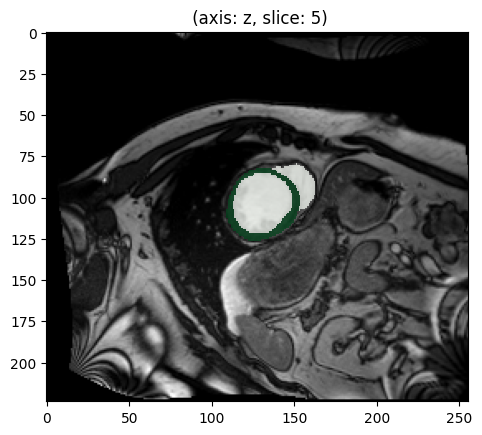

In [51]:
def visualize_sample(dataset, sample, state, axis, slice, title=None):
    # Visualize the image and overlay the mask, using the dataset as input. Make sure you feed this a nifti or numpy image, no other formats
    print('start visualize sample')
    img_data = dataset[sample][f'{state}_img']
    mask_data = dataset[sample][f'{state}_mask']
    
    # Convert to numpy if necessary
    if isinstance(img_data, np.ndarray):
        img_array = img_data
        mask_array = mask_data
    else:
        img_array = img_data.numpy()
        mask_array = mask_data.numpy()
    img_array=np.squeeze(img_array)
    mask_array=np.squeeze(mask_array)
    
    # Get the data of the given axis
    if axis == 'x':
        img_plane = img_array[slice, :, :]
        mask_plane = mask_array[slice, :, :]
    elif axis == 'y':
        img_plane = img_array[:, slice, :]
        mask_plane = mask_array[:, slice, :]
    elif axis == 'z':
        img_plane = img_array[:, :, slice]
        mask_plane = mask_array[:, :, slice]

    # Plot the image and overlay the mask
    plt.figure()
    plt.imshow(img_plane, 'gray')

    overlay_mask = np.ma.masked_where(mask_plane == 0, mask_plane == 2) # this masks elements in the mask that are 0, and leaves elements that are 1 unmasked
    plt.imshow(overlay_mask, 'Greens', alpha=0.7, clim=[0, 1], interpolation='nearest')

    
    if title is not None:
        plt.title(title)
    
    print('img shape',img_plane.shape)
    plt.show()

# Visualize a sample
sample = 3
state = 'ED'
axis = 'z'
slice = 5
path = train_dataset.data[sample][f'{state}_mask'][0]
visualize_sample(train_dataset, sample, state, axis, slice, title=f"{os.path.basename(path)} (axis: {axis}, slice: {slice})") # the get_filenames function needs the og dict, so you need to put dataset.data

In [ ]:
# Function with which we can easily keep track of the transforms: necessary for wandb to recognise them (compose to list and the otherway around)
def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    /!\ Random seed is not saved, then reproducibility is not enabled.
    """
    from copy import deepcopy
        
    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")
    
    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))
        
        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list

def from_list_to_compose(transform_list):
    """
    Transform a list in the corresponding monai.transforms.Compose object.
    """
    
    if not isinstance(transform_list, list):
        raise TypeError("transform_list should be a list.")
    
    pre_compose_list = list()
    
    for transform_dict in transform_list:
        if not isinstance(transform_dict, dict) or 'class' not in transform_dict or 'kwargs' not in transform_dict:
            raise TypeError("transform_list should only contains dicts with keys ['class', 'kwargs']")
        
        try:
            transform = transform_dict['class'](**transform_dict['kwargs'])
        except TypeError: # Classes have been converted to str after saving
            transform = eval(transform_dict['class'].replace("__main__.", ""))(**transform_dict['kwargs'])
            
        pre_compose_list.append(transform)
        
    return monai.transforms.Compose(pre_compose_list)

In [ ]:
# Data augmentation and making datasets for training and validation:

# Define the keys so that the transforms can be split into images and masks (needed for the randrotated):
keys_img = ['ES_img', 'ED_img']
keys_mask = ['ES_mask','ED_mask']
maxlen = 512 # maximum dimension of the original samples, so resize to that dimension
max_size = [512, 512, 16]
roi_size = [336,336,16]

# Only the necessary transforms to be able to load the data into the UNet. This will be applied to all keys present: 
T_val = monai.transforms.Compose([
    LoadData(),
    # A add dimension
    monai.transforms.AddChanneld(keys=val_dict[0].keys()),
    # Scale intesities between 0 and 1
    monai.transforms.ScaleIntensityd(keys = keys_img, minv = 0, maxv = 1),
    # Resize the images and masks
    monai.transforms.Resized(keys=val_dict[0].keys(),size_mode='all',spatial_size=max_size, mode= 'nearest'), # resize to the largest dimension present in the original images    
    # Crop the ROI
    monai.transforms.CenterSpatialCropd(keys=val_dict[0].keys(),roi_size=roi_size), # crop the images so that the UNet trains more quickly
])

# Define the transforms for the training data. This is done for the image and mask seperately due to the monai.transforms.RandRotated. This transform will rotate the keys 'img' and 'mask' randomly, meaning that they will not align anymore, thus we need to define the transforms for the images and masks seperately and set a randomseed afterwards. 
T_train_img1 = monai.transforms.Compose([
    LoadData(),
    monai.transforms.AddChanneld(keys=keys_img),
    monai.transforms.ScaleIntensityd(keys = keys_img, minv = 0, maxv = 1),
    monai.transforms.Resized(keys=keys_img,size_mode='all',spatial_size=max_size, mode= 'nearest'), # resize to the largest dimension present in the original images    
    # Do a rotation of maximun 90 degrees to the left or right
    monai.transforms.RandRotated(keys=keys_img,range_z=np.pi/4, prob=1),
    monai.transforms.CenterSpatialCropd(keys=keys_img,roi_size=roi_size),
    
T_train_img2 = monai.transforms.Compose([
    LoadData(),
    monai.transforms.AddChanneld(keys=keys_img),
    monai.transforms.ScaleIntensityd(keys = keys_img, minv = 0, maxv = 1),
    monai.transforms.Resized(keys=keys_img,size_mode='all',spatial_size=max_size, mode= 'nearest'), # resize to the largest dimension present in the original images    
    monai.transforms.CenterSpatialCropd(keys=keys_img,roi_size=roi_size),
    # Add Gaussian noise
    monai.transforms.RandGaussianNoised(keys=keys_img,prob=1,mean=0.02,std=0.5),
])

T_train_img3 = monai.transforms.Compose([
    LoadData(),
    monai.transforms.AddChanneld(keys=keys_img),
    monai.transforms.ScaleIntensityd(keys = keys_img, minv = 0, maxv = 1),
    monai.transforms.Resized(keys=keys_img,size_mode='all',spatial_size=max_size, mode= 'nearest'), # resize to the largest dimension present in the original images    
    monai.transforms.RandRotated(keys=keys_img,range_z=np.pi/4, prob=1), # al dat mode=bilinearbilinear... gebeuren weggehaald want dat is al default
    monai.transforms.CenterSpatialCropd(keys=keys_img,roi_size=roi_size),
    monai.transforms.RandGaussianNoised(keys=keys_img,prob=1,mean=0.02,std=0.5), # gedaan nu want interpoleren van noise leek ons erger. 10 is ong 2% van maximale waarde van sample 56. stond op 0.1
])

T_train_mask1 = monai.transforms.Compose([
    LoadData(),
    monai.transforms.AddChanneld(keys=keys_mask),
    monai.transforms.Resized(keys=keys_mask,size_mode='all',spatial_size=max_size), # resize to the largest dimension present in the original images    
    monai.transforms.RandRotated(keys=keys_mask,range_z=np.pi/4, prob=1), 
    monai.transforms.CenterSpatialCropd(keys=keys_mask,roi_size=roi_size),
    ])

T_train_mask2 = monai.transforms.Compose([
    LoadData(),
    monai.transforms.AddChanneld(keys=keys_mask),
    monai.transforms.Resized(keys=keys_mask,size_mode='all',spatial_size=max_size), # resize to the largest dimension present in the original images    
    monai.transforms.CenterSpatialCropd(keys=keys_mask,roi_size=roi_size),
    monai.transforms.RandGaussianNoised(keys=keys_mask,prob=1,mean=0.02,std=0.5), # gedaan nu want interpoleren van noise leek ons erger. 10 is ong 2% van maximale waarde van sample 56
])

T_train_mask3 = monai.transforms.Compose([
    LoadData(),
    monai.transforms.AddChanneld(keys=keys_mask),
    monai.transforms.Resized(keys=keys_mask,size_mode='all',spatial_size=max_size), # resize to the largest dimension present in the original images    
    monai.transforms.RandRotated(keys=keys_mask,range_z=np.pi/4, prob=1), # al dat mode=bilinearbilinear... gebeuren weggehaald want dat is al default
    monai.transforms.CenterSpatialCropd(keys=keys_mask,roi_size=roi_size),
    monai.transforms.RandGaussianNoised(keys=keys_mask,prob=1,mean=0.02,std=0.5), # gedaan nu want interpoleren van noise leek ons erger. 10 is ong 2% van maximale waarde van sample 56
])

# Set random seed so that the mask and image are rotated with the same randomness (so they'll always align):
randseed = random.randrange(0,100)
T_train_img1.set_random_state(seed=randseed)
T_train_mask1.set_random_state(seed=randseed)
T_train_img2.set_random_state(seed=randseed)
T_train_mask2.set_random_state(seed=randseed)
T_train_img3.set_random_state(seed=randseed)
T_train_mask3.set_random_state(seed=randseed)

# Make validation and training datasets
val_dataset_T = monai.data.CacheDataset(val_dict, transform=T_val) # transforms necessary for the UNet

train_dataset_T = monai.data.CacheDataset(train_dict, transform=T_val) # original training dataset with only the necessary transforms
train_dataset_T_img1 = monai.data.CacheDataset(train_dict, transform=T_train_img1) # augmented image data
train_dataset_T_mask1 = monai.data.CacheDataset(train_dict, transform = T_train_mask1) # augmented mask data
train_dataset_T_img2 = monai.data.CacheDataset(train_dict, transform=T_train_img2) # augmented image data
train_dataset_T_mask2 = monai.data.CacheDataset(train_dict, transform = T_train_mask2) # augmented mask data
train_dataset_T_img3 = monai.data.CacheDataset(train_dict, transform=T_train_img3) # augmented image data
train_dataset_T_mask3 = monai.data.CacheDataset(train_dict, transform = T_train_mask3) # augmented mask data

In [ ]:
plt.figure()
plt.imshow(train_dataset_T_img2[10]['ED_img'][0,:,:,3],cmap= 'gray')
plt.show


In [ ]:
# Combine the training dataset for the image and mask so that they're matched to each other again. This is quite computationally expensive, so not recommended for large datasets:
train_dict_T_both = [] # preallocate

for i in range(len(train_dataset_T)): # loop over the length of the dataset, so over all samples (patients)
    dict_list = {'ES_img': train_dataset_T_img1[i]['ES_img'],
                 'ES_mask': train_dataset_T_mask1[i]['ES_mask'],
                 'ED_img': train_dataset_T_img1[i]['ED_img'],
                 'ED_mask': train_dataset_T_mask1[i]['ED_mask']}
    train_dict_T_both.append(dict_list)
    dict_list = {'ES_img': train_dataset_T_img2[i]['ES_img'],
                 'ES_mask': train_dataset_T_mask2[i]['ES_mask'],
                 'ED_img': train_dataset_T_img2[i]['ED_img'],
                 'ED_mask': train_dataset_T_mask2[i]['ED_mask']}
    train_dict_T_both.append(dict_list)
    dict_list = {'ES_img': train_dataset_T_img3[i]['ES_img'],
                 'ES_mask': train_dataset_T_mask3[i]['ES_mask'],
                 'ED_img': train_dataset_T_img3[i]['ED_img'],
                 'ED_mask': train_dataset_T_mask3[i]['ED_mask']}
    train_dict_T_both.append(dict_list)
    
train_dataset_T_both = monai.data.CacheDataset(train_dict_T_both) # make dataset out of appended list
print('length augmented dataset', len(train_dataset_T_both))


In [ ]:
# Now combine the augmented training dataset and the original training dataset to get more training data
datasets_list = [train_dataset_T, train_dataset_T_both] #1, train_dataset_T_both2] # make list of the augmented training data and the original training data with only the necessary transforms
train_dataset_TOG = torch.utils.data.ConcatDataset(datasets_list) # make dataset out of the combined datasets

plt.figure()
plt.imshow(train_dataset_TOG[350]['ED_img'][0,:,:,3])
plt.show


In [ ]:
# Visualize a sample
sample = 34 # kleinste is sample 44, 64 en 77, grootste is 94. Check of de resize is gelukt door naar de geprinte size na de visualize_sample te kijken
state = 'ED'
axis = 'z'
slice = 7
visualize_sample(train_dataset_TOG, sample, state, axis, slice)


In [ ]:
# Make dataloaders for training and validation datasets
batch_size = 8
val_dataloader = DataLoader(val_dataset_T, batch_size=batch_size,shuffle=True) # create batches of 16 images (shuffled)
train_dataloader = DataLoader(train_dataset_TOG, batch_size = batch_size, shuffle = True) 


In [ ]:
import torch
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')


In [ ]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


In [ ]:
# DiceCE loss function
loss_function =  monai.losses.DiceCELoss(sigmoid=True, batch=True)


In [ ]:
# Adam optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [ ]:
# Function that makes a mask of the output labels
def label_to_mask(labels, gt):
    masks = []

    for batch in range(len(labels)):
        if gt == True:
            label = np.array(labels[batch])[0] # make an numpy array from the labels, where we remove the first channel (= 1, was needed for transforms) and take a batch. Original dimensions labels = [1, no_masks, x, y, z]
        else:
            label = np.array(labels[batch])  
        # Split masks into seperate masks based on label number
        mask1 = label == 1 # RV
        mask2 = label == 2 # MYO
        mask3 = label == 3 # LV
        
        # Merge all three masks together, containing values 1, 2, and 3:
        real_ES_mask = [] # preallocate
        real_ES_mask.append(1*mask1)
        real_ES_mask.append(2*mask2)
        real_ES_mask.append(3*mask3)
        masks.append(real_ES_mask)
    masks=monai.data.MetaTensor(np.array(masks))
    return masks

In [ ]:
# To visualize a few results:
import random
import math

def visualize_results(state, slice, model, dataloader):
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():  # turn off gradient computation bc we're not training anymore
        no_batches = len(val_dict)/batch_size # get the total number of batches: no_samples/batch_size
        no_batches = math.trunc(no_batches) # round down so you're certain you don't get a batch that doesn't exist
        batch = random.randrange(start=1, stop=no_batches) # generate random batch number within total number of batches
        
        # Get images and labels from the dataset, and push the images through the model to get an output image
        for batch in dataloader:
            images = batch[f'{state}_img'].float().to(device) 
            labels = batch[f'{state}_mask'].float().to(device)
            output = model(images)
            
            i = random.randrange(images.shape[0]) # generate random sample number for in batch
            j = 2 # mask number, 0 1 or 2
            labelname = ['RV','MYO','LV']
            # Visualize the images, ground truth masks, and model output masks
            img = images[i,:,:,:].cpu().numpy()
            img = np.squeeze(img)
            gt_mask = labels[i,:,:,:].cpu().numpy()
            gt_mask = np.squeeze(gt_mask)
            pred_mask = output[i,j,:,:,:].cpu().numpy()
            # Squeeze the mask where you specified j for
            pred_mask = np.squeeze(pred_mask)
            
            # Plot only z-axis for now
            img_plane = img[:,:,slice]
            gt_mask_plane = gt_mask[:,:,slice]
            pred_mask_plane = pred_mask[:,:,slice]

            # Display the images and masks
            fig, axes = plt.subplots(1, 4, figsize=(12, 4))
            axes[0].imshow(img_plane, cmap='gray')
            axes[0].set_title('OG image')
            axes[1].imshow(gt_mask_plane)
            axes[1].set_title('GT mask')
            axes[2].imshow(pred_mask_plane)
            axes[2].set_title(f'Pred mask with label {labelname[j]}')     
            
            sigmoid = torch.nn.Sigmoid()
            pred_mask0 = 1*torch.round(sigmoid(output[i,0,:,:,:])).cpu().numpy()
            pred_mask1 = 2*torch.round(sigmoid(output[i,1,:,:,:])).cpu().numpy()
            pred_mask2 = 3*torch.round(sigmoid(output[i,2,:,:,:])).cpu().numpy()
            overlay_mask0 = np.ma.masked_where(pred_mask0 == 0, pred_mask0 == 1) # this masks elements in the mask that are 0, and leaves elements that are 1 unmasked
            overlay_mask1 = np.ma.masked_where(pred_mask1 == 0, pred_mask1 == 1)
            overlay_mask2 = np.ma.masked_where(pred_mask2 == 0, pred_mask2 == 1)
            axes[3].imshow(img_plane, cmap='gray')
            axes[3].imshow(overlay_mask0[:,:,slice], 'plasma', alpha=0.7, clim=[0, 1], interpolation='nearest')
            axes[3].imshow(overlay_mask1[:,:,slice], 'plasma', alpha=0.7, clim=[0, 1], interpolation='nearest')
            axes[3].imshow(overlay_mask2[:,:,slice], 'Greens', alpha=0.7, clim=[0, 1], interpolation='nearest')
            axes[3].set_title('Total mask')
            plt.show() 
                


In [ ]:
from tqdm import tqdm
import wandb
from skimage.metrics import structural_similarity as ssim
from datetime import datetime

state = 'ED' # hier en hieronder aanpassen 

wandb.login()
# Make sure all training parameters can be logged to wandb
run = wandb.init(
    project='DLMIA - ACDC project 8.2',
    name=f'Final {state}, lr {lr}, batchsize {batch_size}',
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'transform1': from_compose_to_list(T_train_img1),
        'transform2': from_compose_to_list(T_train_img2),
        'transform3': from_compose_to_list(T_train_img3),
        'transform_standaard': from_compose_to_list(T_val),
        'batch_size': train_dataloader.batch_size,
        'state': state
    }
) 
run_id = run.id # Remember the run ID to be able to write the evaluation metrics

class_labels = {1: 'right_ventricle', 2:'myocardium', 3: 'left_ventricle'}

def wandb_masks(mask_output, mask_gt): # Function that makes a mask dictionary in the required format
    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    tot_mask_out = []
    sigmoid = torch.nn.Sigmoid() 
    mask_output0 = 1*(torch.round(sigmoid(mask_output[0]))).detach().cpu().numpy() # RV
    mask_output1 = 2*(torch.round(sigmoid(mask_output[1]))).detach().cpu().numpy() # MYO
    mask_output2 = 3*(torch.round(sigmoid(mask_output[2]))).detach().cpu().numpy() # LV
    add_mask_out = np.add(mask_output0, mask_output1, mask_output2)
    
    # Transform masks to numpy arrays on CPU
    add_mask_out = add_mask_out.squeeze() #.detach().cpu().numpy()
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()
    
    # Create mask dictionary with class label and insert masks
    masks = {
        'predictions': {'mask_data': add_mask_out, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

# Defining training parameters
val_freq = 10 # the frequency at which data is logged to wandb
n_epochs = 100

# Preallocate:
train_loss = []
val_loss = []
output = [] 
output_tot = []

# Defining training loop
def train_ACDC(state, model, train_dataloader, val_dataloader, optimizer, epochs, val_freq):
    train_loss = []
    val_loss = []

    # Loop ofer all the epochs
    for epoch in tqdm(range(epochs)):
        model.train()
        steps = 0
        epoch_loss = 0

        # Train in mini-batch form
        for batch in train_dataloader:
            optimizer.zero_grad()
            # Image that needs to be classified
            images = batch[f'{state}_img'].float().to(device) 
            
            # Ground truth labels
            labels = batch[f'{state}_mask'].float()
            gt_mask = label_to_mask(labels,True).to(device)

            sigmoid = torch.nn.Sigmoid() 
            
            # Segment the images
            output = model(images)
            
            output_s = torch.round(sigmoid(output))
             
            loss = loss_function(output, gt_mask).to(device)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            steps += 1
        train_loss.append(epoch_loss/steps) 
        
        # validation loop
        if epoch % val_freq == 0:
            steps = 0 # niet in spleen tutorial online
            val_epoch_loss = 0
            model.eval() # put model in evaluation mode since it's gonna loop over the validation dataset (and it does not need to learn from that)
            for batch in val_dataloader:
                images = batch[f'{state}_img'].float().to(device)
                labels = batch[f'{state}_mask'].float()
                gt_mask = label_to_mask(labels, True).to(device)
                output = model(images)
                sigmoid = torch.nn.Sigmoid() 
                output_s = torch.round(sigmoid(output))
                
                loss = loss_function(output, gt_mask).to(device) # val loss
                val_epoch_loss += loss.item()
                steps += 1
            val_loss.append(val_epoch_loss/steps)
            
            log_imgs = [wandb.Image(img[0,:,:,0], masks=wandb_masks(mask_output[:,:,:,0], mask_gt[:,:,:,0])) for img, mask_output, mask_gt in zip(batch[f'{state}_img'], output, batch[f'{state}_mask'])]
            
            wandb.log({'train_loss': train_loss[-1], 'val_loss': val_loss[-1], "images": log_imgs, 'learning rate': lr})
            
            current_day = datetime.now().day
            current_time = datetime.now().strftime("%H:%M:%S")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss[-1],
                'val_loss': val_loss[-1],
                }, f'ACDCtrainedUNet_{state}_lr_{lr}_{current_day}_{current_time}_{epoch}.pt')
           
    return output, labels
    
output_net, labels_net = train_ACDC(state,model, train_dataloader, val_dataloader, optimizer, n_epochs, val_freq)

# Save model with current time stamp:
current_day = datetime.now().day
current_time = datetime.now().strftime("%H_%M_%S")
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'ACDCtrainedUNet_{state}_lr_{lr}_{current_day}_{current_time}_FINAL.pt')

run.finish()
